# Introduction 

Le mapping Relation/Object a pour but de mettre oeuvre déclarativement le lien entre un modèle Orienté Objet (comme un programme Java) et un modèle relationnel (comme des tables dans une base de données relationnelles). Cela peut comprendre la création du schéma relationnel à partir du programme Java et la construction automatique des fonctions de base pour la gestion de la persistence. 

Pour Java, Jakara Persistance API (JPA) est une [spécification (actuellement en version 3.1)](https://jakarta.ee/specifications/persistence/3.1/jakarta-persistence-spec-3.1.html) concernant la liaison entre le modèle orienté objet de Java et le modèle relationnel (Object Relational Mapping - ORM). JPA est construit au dessus de [JDBC](https://docs.oracle.com/javase/8/docs/technotes/guides/jdbc/).

JPA possède trois parties principales : 
 * La description des "entités" persistentes.
 * L'interaction de base (CRUD) avec la persistence.
 * L'interrogation native ou via un langage dédié.
 
 
JPA génère donc automatiquement les requêtes SQL et leur mise en oeuvre avec JDBC. 

Plusieurs implantations de JPA existent dont l'implantation de référence [EclipseLink](https://www.eclipse.org/eclipselink)) et une autre très utilisée [Hibernate](https://hibernate.org/). Cette introduction utilise Hibernate mais en respectant le standard.

In [1]:
%%loadFromPOM 
  <dependency>
    <groupId>jakarta.persistence</groupId>
    <artifactId>jakarta.persistence-api</artifactId>
    <version>3.1.0</version>
  </dependency>
  <dependency>
    <groupId>org.hibernate.orm</groupId>
    <artifactId>hibernate-core</artifactId>
    <version>6.1.7.Final</version>
  </dependency>
  
  <!--dependency>
    <groupId>org.eclipse.persistence</groupId>
    <artifactId>eclipselink</artifactId>
    <version>4.0.1</version>
  </dependency-->

Pour utiliser JPA, il faut une base de données relationnelle. Nous utiliserons ici [H2](https://www.h2database.com).

In [2]:
%%shell
docker stop H2-JPADemo
docker volume rm  h2-data
docker pull brunoe/docker-database-h2:develop

H2-JPADemo
h2-data
develop: Pulling from brunoe/docker-database-h2
Digest: sha256:041fbb12efc0f6013c521e66e4f21ffefef3e60dc336c1d5a45603ae1b2aa414
Status: Image is up to date for brunoe/docker-database-h2:develop
docker.io/brunoe/docker-database-h2:develop


In [3]:
%%shell
docker start H2-JPADemo || \
docker run --quiet --detach --rm \
    --name=H2-JPADemo \
    -e PUID=$UID -e PGID=$GID \
    -e H2_ARGS="-tcp -tcpAllowOthers -ifNotExists" \
    -p 9092:9092 \
    -v h2-data:/opt/h2-data \
    brunoe/docker-database-h2:develop

Error response from daemon: No such container: H2-JPADemo
Error: failed to start containers: H2-JPADemo


ece9ff8fd5308cb6ee5e1a96afdb2c3956a07b0affbd515d1587115c1b484046


In [4]:
%%shell
(cd samples/hellojpa && mvn --quiet clean package )

In [5]:
%jars samples/hellojpa/target/*-SNAPSHOT-jar-with-dependencies.jar

import jakarta.persistence.*;
import fr.univtln.bruno.demos.jpa.hello.DatabaseManager;

System.setProperty("jakarta.persistence.jdbc.url","jdbc:h2:tcp://host.docker.internal/hellojpa-db");

try (EntityManager em = DatabaseManager.ENTITY_MANAGER_FACTORY.createEntityManager();
    ) {}

20:32:01.775 INFO  f.u.b.d.jpa.hello.DatabaseManager - Override JPA config jakarta.persistence.jdbc.url with system property jakarta.persistence.jdbc.url
20:32:01.777 INFO  f.u.b.d.jpa.hello.DatabaseManager - Override JPA config jakarta.persistence.jdbc.user with system property jakarta.persistence.jdbc.user
20:32:01.777 INFO  f.u.b.d.jpa.hello.DatabaseManager - Override JPA config jakarta.persistence.jdbc.password with system property jakarta.persistence.jdbc.password
20:32:03.408 INFO  com.mchange.v2.log.MLog - MLog clients using slf4j logging.
20:32:03.654 INFO  SQL dialect - HHH000400: Using dialect: org.hibernate.dialect.H2Dialect
20:32:04.180 WARN  o.h.t.s.i.ExceptionHandlerLoggedImpl - GenerationTarget encountered exception accepting command : Error executing DDL "drop table if exists EX_SIMPLE.CUSTOMER cascade " via JDBC Statement
org.hibernate.tool.schema.spi.CommandAcceptanceException: Error executing DDL "drop table if exists EX_SIMPLE.CUSTOMER cascade " via JDBC Statement
	

In [6]:
import org.slf4j.Logger;
import org.slf4j.LoggerFactory;

Logger log = LoggerFactory.getLogger("Notebook");

## Les entités

Avec JPA une classe dont les instances doivent être persistantes est appelée une entité. Techniquement, une classe est une entité si elle annotée avec [@Entity](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/entity), qu'un ou plusieurs de ses attributs sont annotés avec [@Id](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/id) et qu'elle a au moins un constructeur sans paramètre (au plus `protected`). La classe sera alors associée à une relation du même nom, ayant une clé primaire (atomique ou composite)

La classe suivante est donc entité JPA :

In [7]:
%%javasrcClassByName Customer
samples/hellojpa/src/main/java/fr/univtln/bruno/demos/jpa/hello/samples/ex_simple/Customer.java

```Java
@Entity
@Data
@RequiredArgsConstructor(staticName = "of")
@NoArgsConstructor(access = AccessLevel.PROTECTED)
@Setter
public class Customer {

    @Id
    @GeneratedValue
    private long id;

    @NonNull
    private String email;

    private String name;
}
```

associée à la relation :

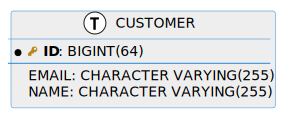

In [8]:
%%rdbmsSchema jdbc:h2:tcp://host.docker.internal/hellojpa-db dba secret EX_SIMPLE
CUSTOMER

In [9]:
%%shell 
java -cp h2*.jar org.h2.tools.Shell \
  -url "jdbc:h2:tcp://host.docker.internal/hellojpa-db" \
  -user dba -password secret -sql "SHOW COLUMNS FROM EX_SIMPLE.CUSTOMER"

FIELD | TYPE                   | NULL | KEY | DEFAULT
ID    | BIGINT                 | NO   | PRI | NULL
EMAIL | CHARACTER VARYING(255) | YES  |     | NULL
NAME  | CHARACTER VARYING(255) | YES  |     | NULL
(3 rows, 10 ms)


Le mapping peut être contrôllé finement par un ensemble d'annotations. La classe suivante illustre celles de base. 

In [10]:
%%javasrcClassByName Customer
samples/hellojpa/src/main/java/fr/univtln/bruno/demos/jpa/hello/samples/ex_entity/Customer.java

```Java
@Entity
@Data
@Builder
@AllArgsConstructor
@RequiredArgsConstructor(staticName = "of")
@NoArgsConstructor(access = AccessLevel.PROTECTED)
@Table(name = "CUSTOMER", indexes = { @Index(name = "idx_email", columnList = "email", unique = true) })
public class Customer {

    @Column(updatable = false)
    private final LocalDateTime creationDate = LocalDateTime.now();

    @Id
    @Column(name = "ID")
    @GeneratedValue
    private long id;

    @Column(length = 50, nullable = false, unique = true)
    @NonNull
    private String email;

    @Column(length = 50, nullable = false)
    private String firstname;

    @Column(length = 50, nullable = false)
    private String lastname;

    @Transient
    private String displayName;

    private LocalDate birthDate;

    @Lob
    @Basic(fetch = FetchType.LAZY)
    private byte[] photo;

    // @Enumerated(EnumType.STRING)
    private Status status = Status.LEAD;

    public void setBirthDate(LocalDate birthDate) {
        this.birthDate = birthDate;
    }

    enum Status {

        ACTIVE, LEAD
    }
}
```

[@Entity](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/entity) indique qu'une classe est une entité et permet de contrôler son nom (par défaut celui de la classe).

[@Id](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/id) est obligatoire et défini le ou les attributs qui compose la clé primaire.

[@Table](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/table) contrôle finement le mapping au niveau de la table associée (nom spécifique, schema, catalogue, contraintes et [index](https://jakarta.ee/specifications/persistence/2.2/apidocs/javax/persistence/))

[@Basic](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/basic) est l'annotation pour tout ce qui peut etre représenté directement comme un attribut : les primitifs (et leurs classes d'enveloppement), les chaînes de caractères, les types temporels, les octets ou tableaux d'octets, les énumérés et tout ce qui implante l'interface Serialisable. Cette annotation est optionnelle et permet de d'indiquer si l'attribut peut être nul dans la base (`optional`) et s'il doit être récupéré au changement de classe (par défaut, [fetch](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/fetchtype)=EAGER) ou uniquement lors de l'accès au membre (fetch=LAZY).

[@Column](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/column) contrôle finement la colonne associée au membre comme son nom ou ses contraintes (null, insertion ou mise à jour autorisés ou non ; unicité ; ...).

[@GeneratedValue](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/generatedvalue)  contrôle la méthode utilisée pour généré la clé lors de l'insertion (automatique pour s'adapater à la base de données utilisée, identité pour MySQL, séquence pour ceux qui le supporte ou Table qui est portable mais avec les moins bonnes performances et récement UUID). 

[@Transient](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/transient) permet d'indiquer qu'un membre ne doit pas être persistant (s'il porte le modificateur `transient` c'est aussi le cas).

[@Lob](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/lob) permet d'associer des grands objets binaires ou textes (BLOB et CLOB).

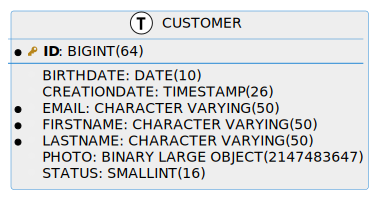

In [11]:
%%rdbmsSchema jdbc:h2:tcp://host.docker.internal/hellojpa-db dba secret
CUSTOMER

In [12]:
%%shell 
java -cp h2*.jar org.h2.tools.Shell \
  -url "jdbc:h2:tcp://host.docker.internal/hellojpa-db" \
  -user dba -password secret -sql "SHOW COLUMNS FROM CUSTOMER"

FIELD        | TYPE                  | NULL | KEY | DEFAULT
ID           | BIGINT                | NO   | PRI | NULL
BIRTHDATE    | DATE                  | YES  |     | NULL
CREATIONDATE | TIMESTAMP(6)          | YES  |     | NULL
EMAIL        | CHARACTER VARYING(50) | NO   | UNI | NULL
FIRSTNAME    | CHARACTER VARYING(50) | NO   |     | NULL
LASTNAME     | CHARACTER VARYING(50) | NO   |     | NULL
PHOTO        | BINARY LARGE OBJECT   | YES  |     | NULL
STATUS       | SMALLINT              | YES  |     | NULL
(8 rows, 8 ms)


## Le gestionnaire d'entités

Pour gérer les entité JPA s'appuie sur l'[entity manager](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/entitymanager) (EM). Il fournit les opération CRUD de base et uen interface pour exécuter des requêtes. L'EM s'appuie sur des unités de persistances (des connexions à une base de données) qui sont définie dans un fichier XML `META-INF/persistence.xml` à la racine du classpath (donc dans `src/main/resources` avec Maven). Son schéma est défini dans le standard [https://jakarta.ee/xml/ns/persistence]([https://jakarta.ee/xml/ns/persistence) . Un exemple de base est donné ci-dessous : 


```{literalinclude} sample/META-INF/persistence.xml
:language: xml
:caption: META-INF/persistence.xml
:name: META-INF/persistence.xml
```

### Création de l'EM et persistence d'une entité

Pour obtenir un EM, on utilise l'[EntityManagerFactory](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/entitymanagerfactory) (EMF) en indiquant le nom d'une persistence unit.
La génération automatique éventuelle à lieu lors de la première utilise de l'EMF. 

A partir de l'entity manager, il est alors possible de commencer une transaction (`begin`), de rendre persistante une instance (`persist`) et de terminer la transcation (`commit` ou `rollback`).
On note la mise à jour automatique de l'entity avec l'ID généré par la base de données. L'entity manager est prévu pour une locale et généralement brève, il doit être fermé après utilisation (`autocloseable`).

```java
try (EntityManagerFactory emf = Persistence.createEntityManagerFactory("hellojpa-pu")) 
{
    try (EntityManager entityManager = emf.createEntityManager()) {
    }
}    
```

La création d'un EMF est couteuse, on utilise donc généralement un singleton pour gérer l'EMF. 

In [13]:
import fr.univtln.bruno.demos.jpa.hello.samples.ex_simple.*;
import fr.univtln.bruno.demos.jpa.hello.DatabaseManager;

try (EntityManager entityManager = DatabaseManager.ENTITY_MANAGER_FACTORY.createEntityManager()) {
        entityManager.getTransaction().begin();

        Customer customer = Customer.of("pierre.durand@ici.fr");
        System.out.println("BEFORE PERSIST "+customer.toString());

        entityManager.persist(customer);
        System.out.println("AFTER PERSIST: "+customer.toString());
        entityManager.getTransaction().commit();
}

BEFORE PERSIST Customer(id=0, email=pierre.durand@ici.fr, name=null)
AFTER PERSIST: Customer(id=1, email=pierre.durand@ici.fr, name=null)


A partir du moment ou une entité est liée au contexte de persistence (en venant d'être crée ou récupérée), la mise à jour dans la base est implicite (par de fonction dédié de l'entity manager). La transaction n'est nécessaire que pour les modifications.

In [14]:
try (EntityManager entityManager = 
  DatabaseManager.ENTITY_MANAGER_FACTORY.createEntityManager()) {
    entityManager.getTransaction().begin();
    Customer customer = Customer.of("pierre.durand@ici.fr");
    entityManager.persist(customer);
    
    customer.setName("Pierre");
        
    entityManager.getTransaction().commit();
}

L'entity manager propose une méthode de recherche par ID `find()` qui prend en paramètre la classe de l'entité recherche et la valeur de la clé. 

In [15]:
try (EntityManager entityManager = DatabaseManager.ENTITY_MANAGER_FACTORY.createEntityManager()) {
    Optional<Customer> customer = Optional.ofNullable(entityManager.find(Customer.class, 1L));
    
    if (customer.isEmpty()) 
        System.out.println("Id 1 not in database.");
    else {
        System.out.println("Search cust. Id 1: "+customer);
     }
}

Search cust. Id 1: Optional[Customer(id=1, email=pierre.durand@ici.fr, name=null)]


`merge` attacher un objet au contexte de persistence (par son id), `refresh` annule les modifications en cours de transanction sur une entity et `detach` indique à l'EM de ne plus gérer une entité.

In [16]:
Customer customer = Customer.of("pierre.durand@ici.fr");
customer.setId(1L);
System.out.println("BEFORE MERGE "+customer.toString());

try (EntityManager entityManager = DatabaseManager.ENTITY_MANAGER_FACTORY.createEntityManager()) {
    entityManager.getTransaction().begin();
    customer =  entityManager.merge(customer);
    entityManager.refresh(customer);
    entityManager.getTransaction().commit();    
}

System.out.println("AFTER MERGE+REFRESH "+customer.toString());

BEFORE MERGE Customer(id=1, email=pierre.durand@ici.fr, name=null)
AFTER MERGE+REFRESH Customer(id=1, email=pierre.durand@ici.fr, name=null)


L'entity manager propose une méthode `remove` pour supprimer une entité de la base de données. 

In [17]:
try (EntityManager entityManager = DatabaseManager.ENTITY_MANAGER_FACTORY.createEntityManager()) {
    Optional<Customer> customer = Optional.ofNullable(entityManager.find(Customer.class, 1L));
    
    if (customer.isEmpty()) 
        System.out.println("Id 1 not in database.");
    else {
        entityManager.getTransaction().begin();
        entityManager.remove(customer.get());
        entityManager.getTransaction().commit();
    }
}